# Part II - Explanatory Analysis - Airline Dataset

## Investigation Overview

When we look at flight delays more closely, clear timing and reporting patterns jump out. Delays aren’t evenly spread across the day or week — they build up around busy periods, especially late afternoons on weekdays, while quieter times see flights running much more smoothly. At the same time, some recorded “causes” don’t quite add up, raising questions about how airlines log their delays.

The figures here highlight that congestion, timing, and operational practices often matter more than distance or weather. In fact, what looks like “weather” delays sometimes turns out to be more about reporting habits than actual conditions. Together, these insights point to a system where delays compound and feed off one another, shaped just as much by people and processes as by external factors.

## Dataset Overview and Executive Summary

The dataset used here is a subset of the Flights dataset, 'airline_2m.csv', sourced from the Bureau of Transportation Statistics. To focus on meaningful delay analysis, data from years before 2004 were removed because they lacked departure delay causes, and 2020 data were dropped due to having roughly half the usual rows. Cancelled or diverted flights were excluded, along with any columns related only to these cases, leaving just over 1 million rows. All times are in hhmm format (e.g., 1607 = 16:07), and the dataset contains variables covering dates, airline and airplane info, departure and arrival details, and airborne metrics, along with delay causes such as `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, and `LateAircraftDelay`.

The upcoming figures highlight patterns in flight delays across different contexts. **Figure 1** shows how average delays vary by time of day, **Figure 2** examines arrival delays across days of the week, **Figure 3** focuses on weather-related delays across the year, and **Figure 4** explores the relationship between arrival delay and departure delay

These figures provide insight into how variables interact with operational factors like time of day and day of the week. Some trends are intuitive, such as higher delays during peak hours, while others, like the spike on Christmas Eve or the strong link in **Figure 4**, reveal patterns worth closer attention.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load dataset
df = pd.read_csv('airline_subset.csv')

In [3]:
# catching indexes with wrong airtime
airtime_errors_index = []
for i in df[df['AirTime']<10].index: # targetting flights with airtime<10
    if (df.loc[i, 'AirTime']<9) | (df.loc[i,'ActualElapsedTime']/df.loc[i,'CRSElapsedTime']<=0.9): # < 9/10th of the predicted time
        airtime_errors_index.append(i)
# removing rows with wrong airtime and resetting index
df = df[~df.index.isin(airtime_errors_index)].reset_index(drop=True)

## Figure 1 - Wave-like pattern in mean delay distributions

This plot shows the mean DepDelay and ArrDelay at different times of day, resulting in a sideways wave-like pattern.

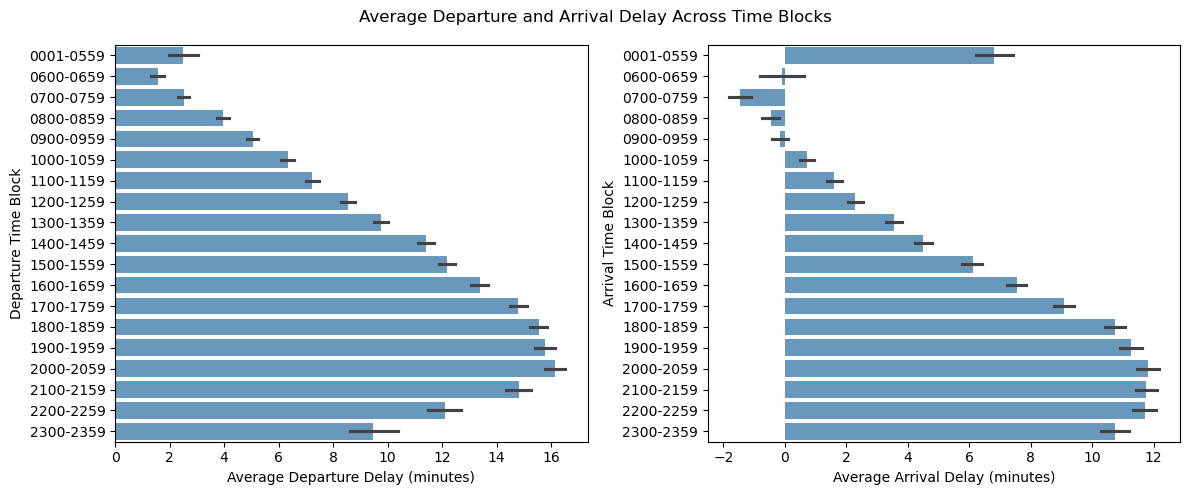

In [4]:
# creating labels for time blocks
time_blocks = ['0001-0559']
for i in range(6,10):
    time_blocks.append(f'0{i}00-0{i}59')
for i in range(10,24):
    time_blocks.append(f'{i}00-{i}59')

# figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# left plot
sns.barplot(data=df, y='DepTimeBlk', x='DepDelay', order=time_blocks, errorbar=('ci',95), orient='h', color='#5A9BCB', ax=ax1)
ax1.set_xlabel('Average Departure Delay (minutes)')
ax1.set_ylabel('Departure Time Block')

# right plot
sns.barplot(data=df, y='ArrTimeBlk', x='ArrDelay', order=time_blocks, errorbar=('ci',95), orient='h', color='#5A9BCB', ax=ax2)
ax2.set_xlabel('Average Arrival Delay (minutes)')
ax2.set_ylabel('Arrival Time Block')

plt.suptitle('Average Departure and Arrival Delay Across Time Blocks')
plt.tight_layout();

**Observation**: Average delays across time blocks show a clear rhythm: mornings (6–10am) are smooth sailing, while delays build up throughout the day, peaking in the evening. The pattern looks almost like a wave, suggesting that delays stack on top of each other as the day goes on. It’s not just random bad luck — peak travel times and crowded skies play a big role in how these delays unfold. The curve formed in the right hand plot is smoother than the left, which is because arrival delays have more "randomness" than departure delays. For example, if a flight is ahead of schedule, airlines usually hold it rather than departing 15 minutes early for no reason, which doesn’t happen with arrivals.

## Figure 2 - Thursday-Friday congestion

This plot shows the mean arrival delay across the week via a heatmap, showing high concentration of delays on Thursday and Friday after 5pm.

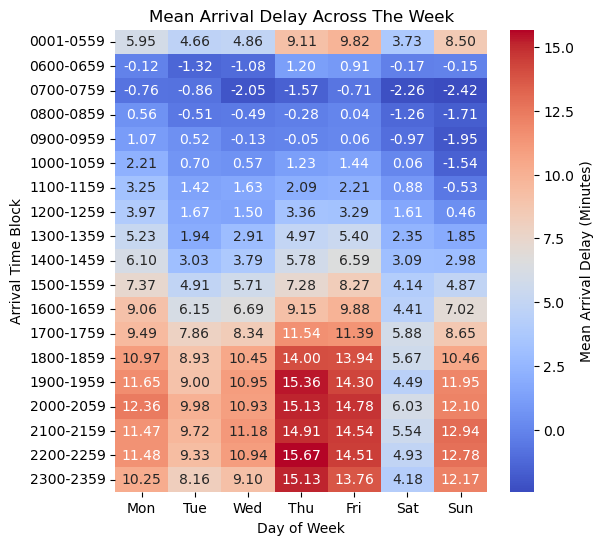

In [5]:
# pivoting data into wide format for heatmap
data=df.groupby(['DayOfWeek', 'ArrTimeBlk'])['ArrDelay'].mean().reset_index(name='ArrDelayMean')
data=data.pivot(columns='DayOfWeek', index='ArrTimeBlk', values='ArrDelayMean')

# figure and plot
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(data=data, cmap='coolwarm', annot=True, fmt='.2f', cbar_kws={'label':'Mean Arrival Delay (Minutes)'}, ax=ax)

# decorations
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax.set_xticklabels(days, rotation=0)
ax.tick_params(axis='y', rotation=0)
plt.ylabel('Arrival Time Block')
plt.xlabel('Day of Week')
plt.title('Mean Arrival Delay Across The Week');

**Observation**: Arrival delays are worst in the evenings, especially Thursday and Friday after 5pm, where the average wait pushes 14 – 15 minutes. This could be a sign of end-of-week congestion. But then Saturday evening tells a different story — delays nearly vanish, dropping to just 5 minutes. With similar schedules in play, this contrast suggests that demand patterns and weekday travel pressures, not just the weather, are driving the late-week crunch.

## Figure 3 - Possible human error in attribution
This plot reveals a possible misattribution of `WeatherDelay` values across the dataset.

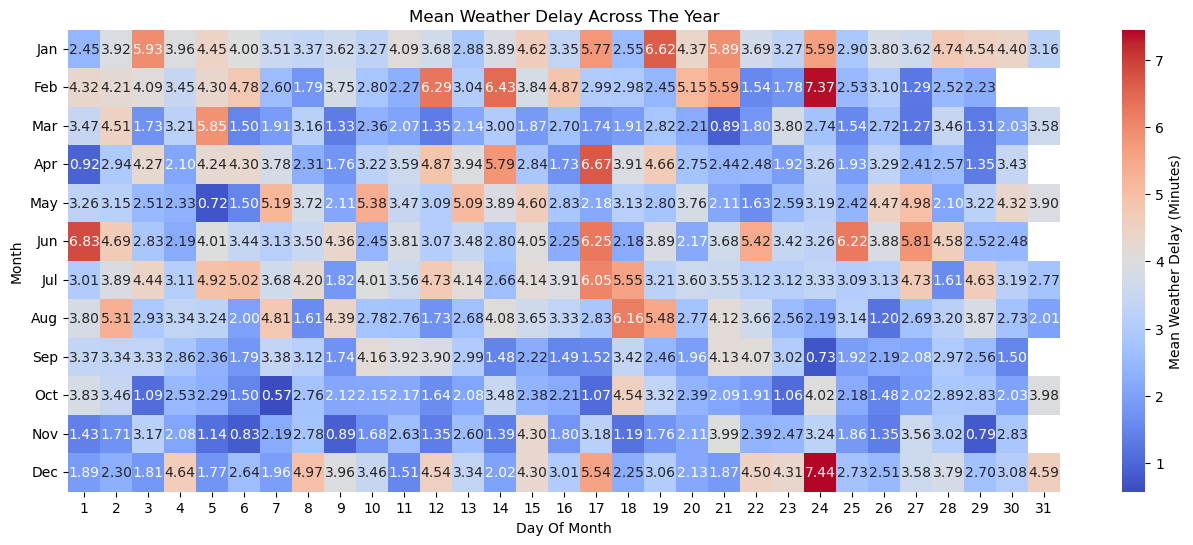

In [6]:
# reveal weather-prone periods in the year.

# pivoting data into wide format for heatmap
data=df[df['DepDelay']>15].groupby(['DayofMonth', 'Month'])['WeatherDelay'].mean().reset_index(name='WeatherDelayMean')
data=data.pivot(columns='DayofMonth', index='Month', values='WeatherDelayMean')

# figure and plot
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(data=data, cmap='coolwarm', annot=True, fmt='.2f', cbar_kws={'label':'Mean Weather Delay (Minutes)'}, ax=ax)

# decorations
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_yticklabels(months, rotation=0)
plt.xlabel('Day Of Month')
plt.title('Mean Weather Delay Across The Year');

**Observation**: December 24th stands out with the highest average weather delays of the year. But this is suspicious — plenty of winter days with worse conditions don’t show the same spike. The more likely explanation is reporting quirks: on Christmas Eve, when chaos is expected, some delays may be lumped under “weather” for convenience. It’s a reminder that delay categories aren’t always about the literal cause, but about how airlines choose to record them.

## Figure 4 - Unexpected correlation
This plot unexpectedly reveals a very strong correlation between `ArrDelay >= 15` and `LateAircraftDelay >= 1`

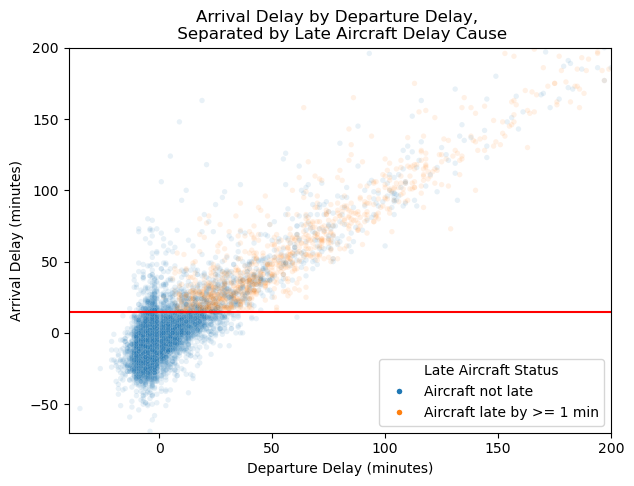

In [7]:
# creating indicator for late aircraft delay column
df['LateAircraftIndicator'] = df['LateAircraftDelay'].apply(lambda x: x if x==0 else 1)

# plot
fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(df[df['DepDelay']!=0].sample(10000), x='DepDelay', y='ArrDelay', alpha=1/10, s=15, hue='LateAircraftIndicator', ax=ax)
plt.xlim(-40, 200)
plt.ylim(-70, 200)
plt.axhline(y=15, color='red') # horizontal line

# decorations
plt.title('Arrival Delay by Departure Delay, \n Separated by Late Aircraft Delay Cause')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')

# custom legend
from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], marker='o', color='w', label='Aircraft not late', markerfacecolor='tab:blue', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Aircraft late by >= 1 min', markerfacecolor='tab:orange', markersize=5)
]
ax.legend(handles=handles, title='Late Aircraft Status');

**Observation**: The scatterplot shows something striking: every single flight flagged with a Late Aircraft Delay also arrived more than 15 minutes late — 100% of them. That’s an unusually perfect correlation. On the other hand, it should be DepDelay >= 15 that splits the hues since LateAircraftDelay is only supposed to be assigned to flights delayed by more than 15 minutes on departure. So why does it not? One possible explanation is that Airlines are already aware if a an aircraft is going to be late, so they speed up the other processes which then results in overall DepDelay of less than 15.